In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'
os.environ["HF_HOME"]="~/codes/.cache/huggingface"

In [2]:
from accelerate.utils import ProjectConfiguration, set_seed

In [3]:
import torch
import random
import numpy as np

def set_seeds(seed):
    set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [4]:
from torchvision import transforms
from diffusers import DDPMPipeline, DDIMPipeline, DDPMScheduler, DDIMScheduler, UNet2DModel

In [5]:
import pickle

In [6]:
class Args():
    
    # model_path = "./saved/5000-0.5/counter/ddpm-sub-0-500-Ours-0"
    model_config_name_or_path="config.json"
    
    dataset_name="cifar10"

    resolution=64
    center_crop=True
    random_flip=False

    dataloader_num_workers=8
    
    seed=42
    gen_seed=0    

    train_batch_size=256

    ddpm_num_steps=1000
    ddpm_num_inference_steps=50
    ddpm_beta_schedule='linear'

args=Args()
args.model_config_name_or_path

'config.json'

In [7]:
with open('./data/indices/5000-0.5/counter/idx-gen-sampled.pkl', 'rb') as handle:
    test_index = pickle.load(handle)
# test_index

In [8]:
with open("./counter/saved.pkl", 'rb') as handle:
    index_image_list = pickle.load(handle)

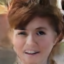

In [9]:
index_image_list[0][0][0]

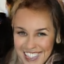

In [10]:
import pandas as pd
df = pd.DataFrame()
df['path'] = ['{}/{}.png'.format('./saved/5000-0.5/gen', i) for i in range(1000)]

from datasets import DatasetDict, Dataset, load_dataset, Image
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": df['path'].tolist(),
}).cast_column("img", Image()),})
gen_dataset = dataset["train"]
gen_dataset[0]['img']

In [11]:
len(index_image_list)

60

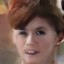

In [12]:
gen_images = [gen_dataset[i]['img'] for i in test_index]
gen_images[0]

In [13]:
random_images = [index_image_list[i][0][0] for i in range(60)]
len(random_images)

60

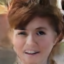

In [14]:
random_images[0]

In [15]:
trak_images = [index_image_list[i][0][1] for i in range(60)]
len(trak_images)

60

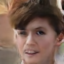

In [16]:
trak_images[0]

In [17]:
ours_images = [index_image_list[i][0][2] for i in range(60)]
len(ours_images)

60

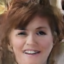

In [18]:
ours_images[0]

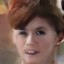

In [19]:
import pandas as pd

from datasets import DatasetDict, Dataset, load_dataset, Image

dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": gen_images,
})}
                     )
gen_dataset = dataset["train"]
gen_dataset[0]["img"]

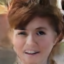

In [20]:
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": random_images,
})}
                     )
random_dataset = dataset["train"]
random_dataset[0]["img"]

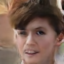

In [21]:
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": trak_images,
})}
                     )
trak_dataset = dataset["train"]
trak_dataset[0]["img"]

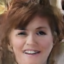

In [22]:
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": ours_images,
})}
                     )
ours_dataset = dataset["train"]
ours_dataset[0]["img"]

In [23]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.0.1+cu117


In [24]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [25]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [26]:
gen_features = []
for i in range(0, len(gen_dataset), 32):
    batch = gen_dataset[i:i+32]['img']
    batch = [preprocess(b) for b in batch]
    batch = torch.tensor(np.stack(batch)).cuda()
    with torch.no_grad():
        image_features = model.encode_image(batch).float()
    print(image_features.size())
    gen_features.append(image_features.cpu().numpy())

torch.Size([32, 512])
torch.Size([28, 512])


In [27]:
random_features = []
for i in range(0, len(random_dataset), 32):
    batch = random_dataset[i:i+32]['img']
    batch = [preprocess(b) for b in batch]
    batch = torch.tensor(np.stack(batch)).cuda()
    with torch.no_grad():
        image_features = model.encode_image(batch).float()
    print(image_features.size())
    random_features.append(image_features.cpu().numpy())

torch.Size([32, 512])
torch.Size([28, 512])


In [28]:
trak_features = []
for i in range(0, len(trak_dataset), 32):
    batch = trak_dataset[i:i+32]['img']
    batch = [preprocess(b) for b in batch]
    batch = torch.tensor(np.stack(batch)).cuda()
    with torch.no_grad():
        image_features = model.encode_image(batch).float()
    print(image_features.size())
    trak_features.append(image_features.cpu().numpy())

torch.Size([32, 512])
torch.Size([28, 512])


In [29]:
ours_features = []
for i in range(0, len(ours_dataset), 32):
    batch = ours_dataset[i:i+32]['img']
    batch = [preprocess(b) for b in batch]
    batch = torch.tensor(np.stack(batch)).cuda()
    with torch.no_grad():
        image_features = model.encode_image(batch).float()
    print(image_features.size())
    ours_features.append(image_features.cpu().numpy())

torch.Size([32, 512])
torch.Size([28, 512])


In [30]:
gen_features_array = np.vstack(gen_features)
random_features_array = np.vstack(random_features)
trak_features_array = np.vstack(trak_features)
ours_features_array = np.vstack(ours_features)

In [31]:
scores_list = []

In [34]:
# # cos
random_scores = np.sum(random_features_array*gen_features_array, axis=1)/(
    np.linalg.norm(random_features_array, axis=1)*np.linalg.norm(gen_features_array,axis=1))
trak_scores = np.sum(trak_features_array*gen_features_array, axis=1)/(
    np.linalg.norm(trak_features_array, axis=1)*np.linalg.norm(gen_features_array,axis=1))
ours_scores = np.sum(ours_features_array*gen_features_array, axis=1)/(
    np.linalg.norm(ours_features_array, axis=1)*np.linalg.norm(gen_features_array,axis=1))

In [35]:
random_scores.mean()

0.95400697

In [42]:
np.median(random_scores)

0.9656005

In [36]:
trak_scores.mean()

0.9261929

In [43]:
np.median(trak_scores)

0.9422942

In [37]:
ours_scores.mean()

0.8907017

In [44]:
np.median(ours_scores)

0.8962557

In [38]:
import matplotlib.pyplot as plt

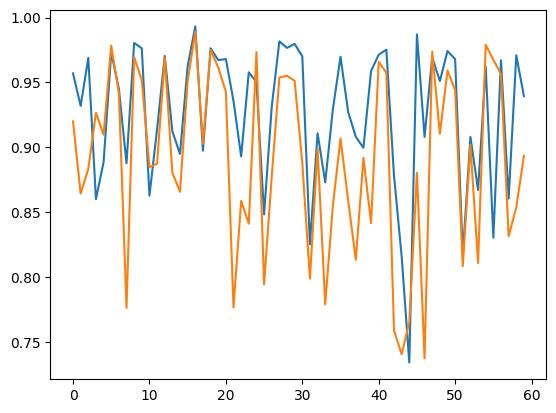

In [39]:
plt.plot(trak_scores)
plt.plot(ours_scores)

In [40]:
df = pd.DataFrame()
df.head()
df['Random'] = random_scores
df['TRAK'] = trak_scores
df['D-TRAK'] = ours_scores
df.head()

,Random,TRAK,D-TRAK
0,0.946908,0.957037,0.920038
1,0.969884,0.931981,0.864312
2,0.956958,0.969012,0.883404
3,0.936845,0.860006,0.926648
4,0.917840,0.888530,0.909689
